In [179]:
import time
import random
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pycoral.utils.edgetpu import make_interpreter
from pycoral.adapters import classify
from pycoral.adapters import common

import tflite_runtime.interpreter as tflite
from imgaug import augmenters as img_aug


In [141]:
def my_imread(image_path):
    image = cv2.imread(str(image_path))
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image


def input_tensor(interpreter):
    tensor_index = interpreter.get_input_details()[0]["index"]
    return interpreter.tensor(tensor_index)()[0]


def img_preprocess(image):
    height, _, _ = image.shape
    image = image[
        int(height / 2) :, :, :
    ]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(
        image, cv2.COLOR_RGB2YUV
    )  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (200, 66))  # input image size (200,66) Nvidia model
    # image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    image = image.astype(np.uint8)
    return image


In [180]:

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image
def blur(image):
    kernel_size = random.randint(
        1, 5
    )  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image, (kernel_size, kernel_size))

    return image
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image, 1)
        steering_angle = 180 - steering_angle

    return image, steering_angle

# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)

    return image, steering_angle

In [184]:
def image_data_generator(image_paths, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)

            image = img_preprocess(image)
            batch_images.append(image)

        yield np.asarray(batch_images)


In [142]:
image_paths = sorted(
    list(Path("train_data_generation/data/drive_with_keypress/").glob("*.png"))
)

train_images = []
for _ in range(20):
    random_index = random.randint(0, len(image_paths) - 1)
    image = my_imread(image_paths[random_index])
    image = img_preprocess(image)
    train_images.append(image)


In [159]:
lane_nav_model_path = Path("lane_navigation/model/lane_navigation_final.h5")
lane_nav_model = tf.keras.models.load_model(lane_nav_model_path)

In [185]:
ncol = 2
nrow = 2

def representative_data_gen():
    input_data = tf.cast(next(image_data_generator(image_paths, nrow, False)), dtype=tf.float32)
    yield [input_data]


converter = tf.lite.TFLiteConverter.from_keras_model(lane_nav_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

lane_nav_tflite_model = converter.convert()

with open("lane_navigation/model/lane_navigation_final.tflite", "wb") as f:
    f.write(lane_nav_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmplx0ejvh3/assets


INFO:tensorflow:Assets written to: /tmp/tmplx0ejvh3/assets
2022-10-22 18:37:07.608930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-10-22 18:37:07.608954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-10-22 18:37:07.609087: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmplx0ejvh3
2022-10-22 18:37:07.610402: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-10-22 18:37:07.610413: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmplx0ejvh3
2022-10-22 18:37:07.614703: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-10-22 18:37:07.658672: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmplx0ejvh3
2022-10-22 18:37:07.671516: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

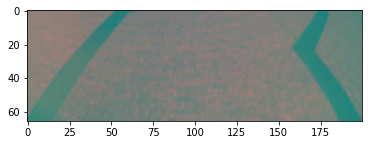

In [186]:
image = cv2.imread(
    "train_data_generation/data/drive_with_keypress/frame_000005_107.09.png"
)
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/frame_000002_97.98.png"
# )
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/frame_000015_126.47.png"
# )
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/frame_000032_60.31.png"
# )

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

proc_image = np.asarray([img_preprocess(image)])

plt.imshow(proc_image[0])


In [187]:

lane_nav_model.predict(proc_image)[0]


array([104.72773], dtype=float32)

In [203]:
def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details["index"]
    input_tensor = interpreter.tensor(tensor_index)()
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    scale, zero_point = input_details["quantization"]
    quantized_input = np.uint8(input / scale + zero_point)
    input_tensor[:, :, :] = quantized_input


def predict_steer(interpreter, input):
    set_input_tensor(interpreter, input)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = interpreter.get_tensor(output_details["index"])
    # Outputs from the TFLite model are uint8, so we dequantize the results:
    scale, zero_point = output_details["quantization"]
    output = scale * (output - zero_point)
    return output


In [204]:
interpreter = tflite.Interpreter(
    model_path="lane_navigation/model/lane_navigation_final.tflite"
)
interpreter.allocate_tensors()

predict_steer(interpreter, proc_image)


array([[105.71855798]])

In [206]:
interpreter = make_interpreter(
    "lane_navigation/model/lane_navigation_final_edgetpu.tflite"
)
interpreter.allocate_tensors()

predict_steer(interpreter, proc_image)


array([[105.71855798]])

In [40]:
common.output_tensor(interpreter, 0)[0]


array([255], dtype=uint8)